# Home Assignment No. 2: Part 2 (Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of our yown code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you may be asked to provide short discussion of the results. In this cases you have to create **MARKDOWN** cell with your comments right after the your code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute `Kernel` -> `Restart Kernel and Run All Cells`, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

Before the start, read several additional recommendations.
* Probably you lauch `jupyter notebook` or `ipython notebook` from linux console. Try `jupyter lab` instead - it is a more convenient environment to work with notebooks.
* Probably the PC on which you are going to evaluate models has limited CPU/RAM Memory. In this case, we recommend to monitor the CPU and Memory Usage. To do this, you can execute `htop` (for CPU/RAM) or `free -s 0.2` (for RAM) in terminal.
* Probably tou have multiple Cores (CPU) on your PC. Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

## Task 1. Deep ANNs. (5 points)

### Task 1.1.  Activation functions. (1 point)


Plot the following [activation functions](https://pytorch.org/docs/master/nn.html#non-linear-activation-functions) using their PyTorch realizations and their derivatives using autograd functionality `grad()`:
   
1. **(1 pt.)** Plot `ReLU`, `ELU` ($\alpha = 1$), `Softplus` ($\beta = 1$) and `Sign`, `Sigmoid`, `Softsign`, `Tanh`.
Which of these functions may be, and which - definitely, are a poor choise as an activation function in a neural network? Why?

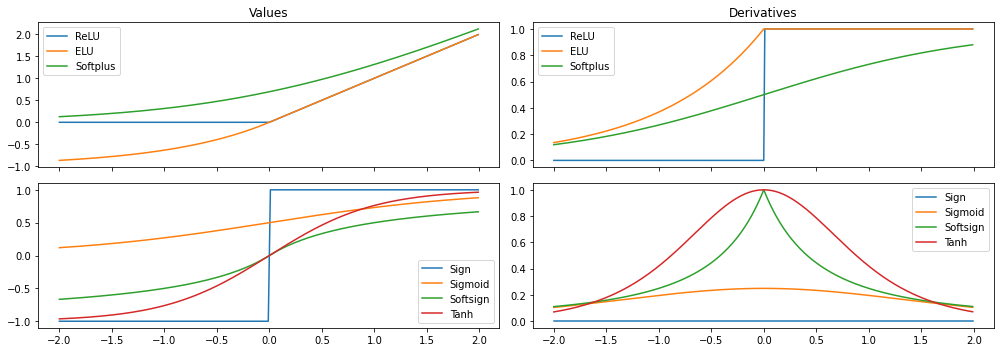

In [2]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

x = torch.arange(-2, 2, .01, requires_grad=True)
x_np = x.detach().numpy()
x.sum().backward() # to create x.grad

f, axes = plt.subplots(2, 2, sharex=True, figsize=(14, 5))
axes[0, 0].set_title('Values')
axes[0, 1].set_title('Derivatives')

for i, function_set in (0, (('ReLU', F.relu), ('ELU', F.elu), ('Softplus', F.softplus))), \
                       (1, (('Sign', torch.sign), ('Sigmoid', torch.sigmoid), ('Softsign', F.softsign), ('Tanh', torch.tanh))):
    for function_name, activation in function_set:
        ### BEGIN Solution
        x.grad.zero_()
        xs = x.detach().numpy()
        values = activation(x).data.numpy()
        activation(x).sum().backward()
        derivatives = x.grad.data.numpy()
        axes[i, 0].plot(xs, values, label = function_name)
        axes[i, 1].plot(xs, derivatives , label=function_name)
        ### END Solution

    axes[i, 0].legend()
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

### Task 1.2. MNIST classification. (4 points)

At the **Seminar 10** on neural networks, we built an MLP (Multilayer perceptron) with one hidden layer using our numpy implementations of linear layer and logistic and softmax activation functions. Your task is to

1. **(1 pt.)** Implement the MPL modules, including the Softmax cross entropy between `logits` and `labels`.
2. **(2 pt.)** Train our numpy realization of MLP to classify the MNIST from `sklearn.datasets()`. Getting accuracy on validation `> 90%`.
3. **(1 pt.)** Compare the acccuracy of classification to your scores from `Part 1` with and without dimensionality reduction. Will be this comparison fair? :) Derive the confusion matrix for all digits classes. What digits were predicted better or worse, than others?


In [394]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [395]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]

input_size = 8*8
classes_n = 10

In [396]:
digits.shape

(1797, 64)

**Implement the MLP with backprop.**

In [397]:
class Linear:
    def __init__(self, input_size, output_size):
        self.thetas = np.random.randn(input_size, output_size)
        self.thetas_grads = np.empty_like(self.thetas)
        self.bias = np.random.randn(output_size)
        self.bias_grads = np.empty_like(self.bias)

    def forward(self, x): 
        self.x = x
        return np.matmul(x, self.thetas) + self.bias
    
    def backward(self, x, output_grad):
        ### BEGIN Solution
        self.thetas_grads += np.dot(self.x.reshape(-1,1), output_grad.T)
        self.bias_grads += np.sum(output_grad, axis=1)
        ### END Solution
        return np.dot(self.thetas, output_grad)
    
class LogisticActivation:
    def forward(self, x):
        self.x = x
        output = 1.0/(1 + np.exp(-x))
        return output


    def backward(self, x, output_grad):
        ### BEGIN Solution
        input_grad =  self.x.reshape(-1, 1) * (1. - self.forward(self.x).reshape(-1, 1)) * output_grad
        ### END Solution
        return input_grad
    

class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)
        
    
    def forward(self, x):
        return np.exp(self.linear2.forward(
            self.activation1.forward(self.linear1.forward(x)))) / np.exp(
            self.linear2.forward(self.activation1.forward(self.linear1.forward(x)))).sum()


    def backward(self, x, output_grad):
        #print('backward_mlp')
        output = self.linear1.backward(x,self.activation1.backward(x,self.linear2.backward(x,output_grad)))
        return output

In [398]:
### BEGIN Solution
def softmax_crossentropy_with_logits(logits, reference_answers):
    logits_vec = np.zeros_like(logits)
    logits_vec[reference_answers] = 1
    return -np.sum(logits_vec * np.log(logits))


def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    logits_vec = np.zeros_like(logits)
    logits_vec[reference_answers] = 1
    out = logits - logits_vec
    return out.reshape(-1, 1)
### END Solution

Starting epoch 0 , Accuracy on test:  0.03777777777777778

Starting epoch 10 , Accuracy on test:  0.4222222222222222

Starting epoch 20 , Accuracy on test:  0.6622222222222223

Starting epoch 30 , Accuracy on test:  0.7244444444444444

Starting epoch 40 , Accuracy on test:  0.7844444444444445

Starting epoch 50 , Accuracy on test:  0.8577777777777778

Starting epoch 60 , Accuracy on test:  0.8844444444444445

Starting epoch 70 , Accuracy on test:  0.9022222222222223

Starting epoch 80 , Accuracy on test:  0.9088888888888889

Starting epoch 90 , Accuracy on test:  0.9222222222222223



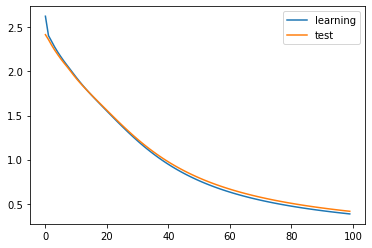

In [399]:
np.random.seed(42)

mlp = MLP(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

epochs_n = 100
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = digits_train
x_test = digits_test
y_train = targets_train
y_test = targets_test

learning_rate = 1e-2

for epoch in range(epochs_n):
        
    for sample_i in range(train_size):
        x = x_train[sample_i].reshape(-1, 1)
        target = np.array([y_train[sample_i]])
        ### BEGIN Solution
        mlp.linear1.thetas_grads = np.zeros_like(mlp.linear1.thetas_grads)
        mlp.linear2.thetas_grads = np.zeros_like(mlp.linear2.thetas_grads)
        mlp.linear1.bias_grads =  np.zeros_like(mlp.linear1.bias_grads)
        mlp.linear2.bias_grads = np.zeros_like(mlp.linear2.bias_grads)
        prediction = mlp.forward(x.reshape(-1))
        
        loss = softmax_crossentropy_with_logits(prediction, target)
        grad_loss = grad_softmax_crossentropy_with_logits(prediction, target)
        
        learning_curve[epoch] += loss
        mlp.backward(x, grad_loss)
        
        mlp.linear1.thetas -= mlp.linear1.thetas_grads * learning_rate
        mlp.linear2.thetas -= mlp.linear2.thetas_grads * learning_rate
        mlp.linear1.bias -= mlp.linear1.bias_grads * learning_rate
        mlp.linear2.bias -= mlp.linear2.bias_grads * learning_rate

        
    learning_curve[epoch] /= train_size
    predictions = []
    for sample_i in range(digits_test.shape[0]):
        x = x_test[sample_i].reshape(-1, 1)
        target = np.array([y_test[sample_i]])
        predictions.append(mlp.forward(x.reshape(-1)))
        loss = softmax_crossentropy_with_logits(predictions[-1], target)
        test_curve[epoch] += loss
    acc = accuracy_score(np.argmax(predictions, axis=1), y_test)

    test_curve[epoch] /=digits_test.shape[0]

    if epoch % 10 == 0:
        print('Starting epoch {}'.format(epoch),', Accuracy on test: ', acc)
        print()

    ### END Solution
plt.plot(learning_curve,label='learning')
plt.plot(test_curve, label='test')
plt.legend()

In [400]:
# confusion matrix
predictions = mlp.forward(digits).argmax(axis = 1)
pd.DataFrame(confusion_matrix(targets, predictions))
# >>> your solution here <<<

0    1    2    3    4    5    6    7    8    9
0  172    0    0    0    1    4    1    0    0    0
1    0  160    4    1    0    0    3    0    3   11
2    1    7  161    7    0    0    0    1    0    0
3    0    0    0  178    0    2    0    2    1    0
4    0    1    0    0  174    0    0    5    1    0
5    0    0    0    1    1  175    1    0    0    4
6    1    3    0    0    1    0  176    0    0    0
7    0    0    0    0    0    1    0  178    0    0
8    0   18    1    5    1    6    1    2  140    0
9    0    3    0   15    5    6    0    8    2  141

- Number 1, 3, 9 and 7 were predicted worse compared to other numbers. Thus is due to some similarity between numbers. The only strange thing is that there are 18 confusions between '1' and '8'. This result is worse compared to KNN with PCA from part 1, but such comparison is not fare since PCA provides great advantage by culling low-variance features.

## Task 2. Autoencoders. (7 points)

### Task 2.1.  Autoencoder on the tabular data. (3 points)


We will biuld the latent representation for tabular data with simple Autoencoding (AE) network. We will work with the cancer dataset from the scikit-learn package. You are to follow the instructions `1.0 - 1.6`.  

1. **(1 pt.)** Implement the AE modules;
2. **(2 pt.)** Train AE to get latent representation of the cancer dataset from `sklearn.datasets()`. Use `MSE` loss and get < $0.28$ on validation, with AE "bottleneck" = $2$;
3. **(1 pt.)** Plot the latent representation of whole dataset in 2D and use colors to show object of differneet classes;

In [10]:
# imports
import sklearn.datasets as sk_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.utils.data as torch_data

#### 1.0 Featch the data. Scale it and split on train and test.

In [11]:
cancer_dset = sk_data.load_breast_cancer()

X = StandardScaler().fit_transform(cancer_dset['data'])

print('Features: ', list(cancer_dset['feature_names']))
print('\nShape:', X.shape)

X_train, X_val, y_train, y_val = train_test_split(X, cancer_dset['target'], test_size=0.2, random_state=42)
print('\nTrain size: ', len(X_train))
print('Validation size: ', len(X_val))

Features:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

Shape: (569, 30)

Train size:  455
Validation size:  114


#### 1.1 Let us firtly make the dataset, which we'll be able to use with pytorch dataloader. 
Implement the `__len__` and `__getitem__` methods.

In [88]:
class CancerData(torch_data.Dataset):
    def __init__(self, X, y):
        super(CancerData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]

In [89]:
train_dset = CancerData(X_train, y_train) 
val_dset = CancerData(X_val, y_val) 

print(train_dset[5])

(tensor([[ 0.1172,  1.9199,  0.1961,  0.0111,  1.2482,  1.0453,  0.9429,  0.6376,
          1.7940,  1.1302, -0.1269, -0.3336,  0.0064, -0.1713, -0.4780,  0.9458,
          0.5145, -0.1454, -0.2388,  0.6321,  0.2466,  1.8650,  0.5016,  0.1101,
          1.5532,  2.5664,  2.0649,  0.8617,  2.1310,  2.7793]]), tensor(0.))


#### 1.2 Now, we'll be making a base class for out autoencoder. 
It takes as input encoder and decoder (it will be tow neural networks). Using this two oblects, your task is to implement the forward pass.

In [90]:
class MyFirstAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyFirstAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        """
        Take a mini-batch as an input, encode it to the latent space and decode back to the original space
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """ 
        return self.decoder(self.encoder(x))# >>> your solution here <<<

#### 1.3 It is time to create neural networks for encoder an decoder networks.
Make hidden size of the network to be equal to `2`.

**Hint.** You can use `nn.Sequential` to create your archtectures.

In [175]:
ss = 200
sample_size = X.shape[1]

encoder = nn.Sequential(
                        nn.Linear(sample_size, ss*1),
                       
                        nn.ReLU(inplace=True),
                        nn.Linear(ss*1,2)
                        )  

decoder = nn.Sequential(
                        nn.Linear(2, ss*1),
                  
                        nn.ReLU(inplace=True),
                        nn.Linear(ss*1, sample_size)  
                        )

In [176]:
device = 'cpu'

net = MyFirstAE(encoder, decoder)  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)


train_loader = torch_data.DataLoader(train_dset, batch_size=100, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=100, shuffle=False) 

#### 1.4 Implement the missing parts in the `train` function

In [177]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X, _ in train_loader:
            # >>> your solution here <<<
            X = X.to(device)
            out = net(X)
            loss = criterion(out, X)
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
        # defining NN evaluation
        net.eval()
        for X, _ in val_loader:
            
             # >>> your solution here <<<
            X = X.to(device)
            out = net(X)
            val_loss = criterion(out, X)
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), val_loss.item()))

#### 1.5 Train your AE on breast cancer dataset. 
Your goal is to get validation error < that 0.3.

Some feartures that mey help you to improve performance:
* `Dropout`
* `Batchnorm`
* lr scheduler (e.g. reduce learning)
* Batch size

In [178]:
# for `MSE` loss get < 0.28 on validation, with AE "bottleneck" = 2
train(100, net, criterion, optimizer, train_loader, val_loader, scheduler) 

Epoch 5/100 || Loss:  Train 0.3074 | Validation 0.3220
Epoch 10/100 || Loss:  Train 0.3152 | Validation 0.3057
Epoch 15/100 || Loss:  Train 0.3253 | Validation 0.3101
Epoch 20/100 || Loss:  Train 0.2976 | Validation 0.3164
Epoch 25/100 || Loss:  Train 0.2652 | Validation 0.3101
Epoch 30/100 || Loss:  Train 0.2731 | Validation 0.3056
Epoch 35/100 || Loss:  Train 0.2602 | Validation 0.3042
Epoch 40/100 || Loss:  Train 0.2501 | Validation 0.3055
Epoch 45/100 || Loss:  Train 0.2981 | Validation 0.3002
Epoch 50/100 || Loss:  Train 0.2794 | Validation 0.3088
Epoch 55/100 || Loss:  Train 0.2795 | Validation 0.3000
Epoch 60/100 || Loss:  Train 0.2607 | Validation 0.2974
Epoch 65/100 || Loss:  Train 0.2554 | Validation 0.2915
Epoch 70/100 || Loss:  Train 0.2490 | Validation 0.2821
Epoch 75/100 || Loss:  Train 0.2798 | Validation 0.2881
Epoch 80/100 || Loss:  Train 0.2732 | Validation 0.2751
Epoch 85/100 || Loss:  Train 0.2530 | Validation 0.2722
Epoch 90/100 || Loss:  Train 0.2668 | Validation 

#### 1.6 Let's take a look at the latent space. 
Encode the whole dataset, using your AE, plot it in 2D and use colors to show object of differneet classes

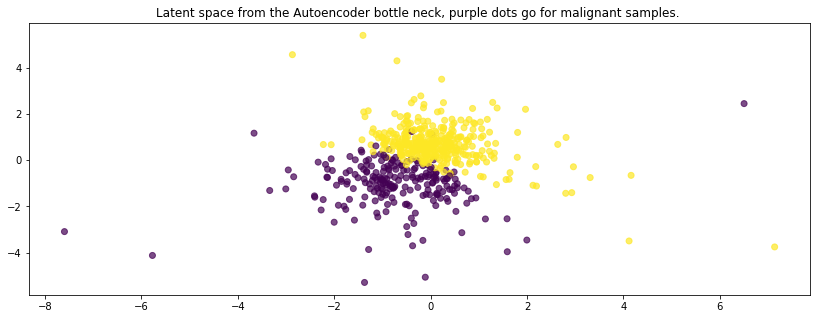

In [179]:
 ### BEGIN Solution
plt.figure(figsize=(14, 5))
net.eval()

enc = net.encoder(torch.from_numpy(X).float()).detach().numpy()
plt.scatter(enc[:,0], enc[:,1], c=cancer_dset['target'], alpha=0.7);
plt.title('Latent space from the Autoencoder bottle neck, purple dots go for malignant samples. ');
 ### END Solution

### Task 2.2.  Autoencoder on kMNIST. (4 points)


We will build the latent representation for `kMRIST` dataset, which you are already familiar with, using our AE network. We will work with the data from `Part 1`.

1. **(2 pt.)** Train AE to get latent representation of the `kMNIST` dataset from `sklearn.datasets()`. Follow the instructions `2.0 - 2.4`. Use `MSE` loss and get < $0.035$ on validation, with AE "bottleneck" < $40$;
2. **(1 pt.)** Plot 10 images and their reconstructions. Plot the latent representation of the whole dataset in 3D, compare visually to your manifold from `Part 1` and upload (pictures) screenshots to this notebook.
3. **(1 pt.)** Get the classification accuracy for the latest features. Use the `KNN` classifier with any hyperparameters you'll choose. Write a couple of sentences comparing the results of `manifold learning` and ` AE`. 
3. **(BONUS 3 pt.)** Sampling from latent representation.

In [401]:
def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('data/kmnist/kmnist-train-imgs.npz')
x_test = load('data/kmnist/kmnist-test-imgs.npz')
y_train = load('data/kmnist/kmnist-train-labels.npz')
y_test = load('data/kmnist/kmnist-test-labels.npz')

# Reshape the data and scale
x_train = x_train.reshape(-1, 28*28)/255# >>> your solution here <<<
x_test = x_test.reshape(-1, 28*28)/255# >>> your solution here <<<

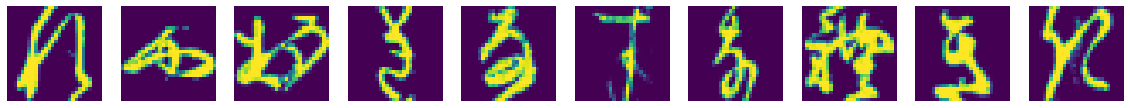

In [402]:
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(x_train[i].reshape(28,28));
    ax[i].axis('off')

In [403]:
class kMNISTData(torch_data.Dataset):
    def __init__(self, X, y):
        super(kMNISTData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)                                                        
        self.y = y.astype(int)
    
    def __len__(self):
        return self.X.shape[0]# >>> your solution here <<<
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]# >>> your solution here <<<

In [404]:
train_kmnist = kMNISTData(x_train, y_train) ### YOUR CODE HERE ###
test_kmnist = kMNISTData(x_test, y_test) ### YOUR CODE HERE ###

#### 2.0 Create encoder and decoder network for kMNIST. 
You can either use convolutions or flatten the images and use linear layers. You can choose hidden size (not larger than 40) and any architecture you like.

In [405]:
x_train.shape

(60000, 784)

In [406]:
sample_size = x_train.shape[1]
ss = 128
encoder = lambda hid: nn.Sequential(
                        nn.Linear(sample_size, ss*4),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss*4, ss*2),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss*2, hid)
                        )
decoder =  lambda hid: nn.Sequential(
                        nn.Linear(hid, ss*2),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss*2, ss*4),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss*4, sample_size)
                 
                        ) 


#### 2.1 Train AE on the kMNIST. 
Your goal is to obtain MSE on the test set < $0.035$ on `MyFirstAE(encoder(40), decoder(40))`.

In [407]:
device = 'cpu'

net = MyFirstAE(encoder(40), decoder(40)) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)

train_loader = torch_data.DataLoader(train_kmnist, batch_size=128, shuffle=True) 
val_loader = torch_data.DataLoader(test_kmnist, batch_size=128, shuffle=False) 

In [408]:
epochs = 100
train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler)

Epoch 5/100 || Loss:  Train 0.0515 | Validation 0.0515
Epoch 10/100 || Loss:  Train 0.0484 | Validation 0.0447
Epoch 15/100 || Loss:  Train 0.0458 | Validation 0.0428
Epoch 20/100 || Loss:  Train 0.0466 | Validation 0.0411
Epoch 25/100 || Loss:  Train 0.0423 | Validation 0.0394
Epoch 30/100 || Loss:  Train 0.0420 | Validation 0.0386
Epoch 35/100 || Loss:  Train 0.0425 | Validation 0.0379
Epoch 40/100 || Loss:  Train 0.0430 | Validation 0.0374
Epoch 45/100 || Loss:  Train 0.0411 | Validation 0.0368
Epoch 50/100 || Loss:  Train 0.0385 | Validation 0.0363
Epoch 55/100 || Loss:  Train 0.0406 | Validation 0.0361
Epoch 60/100 || Loss:  Train 0.0405 | Validation 0.0356
Epoch 65/100 || Loss:  Train 0.0415 | Validation 0.0356
Epoch 70/100 || Loss:  Train 0.0365 | Validation 0.0352
Epoch 75/100 || Loss:  Train 0.0382 | Validation 0.0349
Epoch 80/100 || Loss:  Train 0.0395 | Validation 0.0347
Epoch 85/100 || Loss:  Train 0.0353 | Validation 0.0347
Epoch 90/100 || Loss:  Train 0.0392 | Validation 

#### 2.2 Plot any 10 images and their reconstructions.

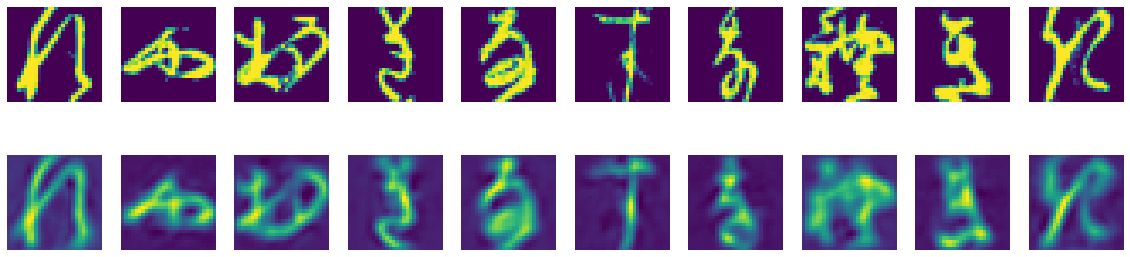

In [409]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
    im = train_kmnist[i][0]
    rec = net(im.reshape(1, 28*28).to(device))
    ax[0, i].imshow(im[0].reshape(28,28));
    ax[1, i].imshow(rec.detach().numpy().reshape(28,28));
    ax[0, i].axis('off')
    ax[1, i].axis('off')

#### 2.3 Plot the latent representation of whole dataset in 3D, compare visually to your manifold from `Part 1` and upload (pictures) screenshoots to this notebook.

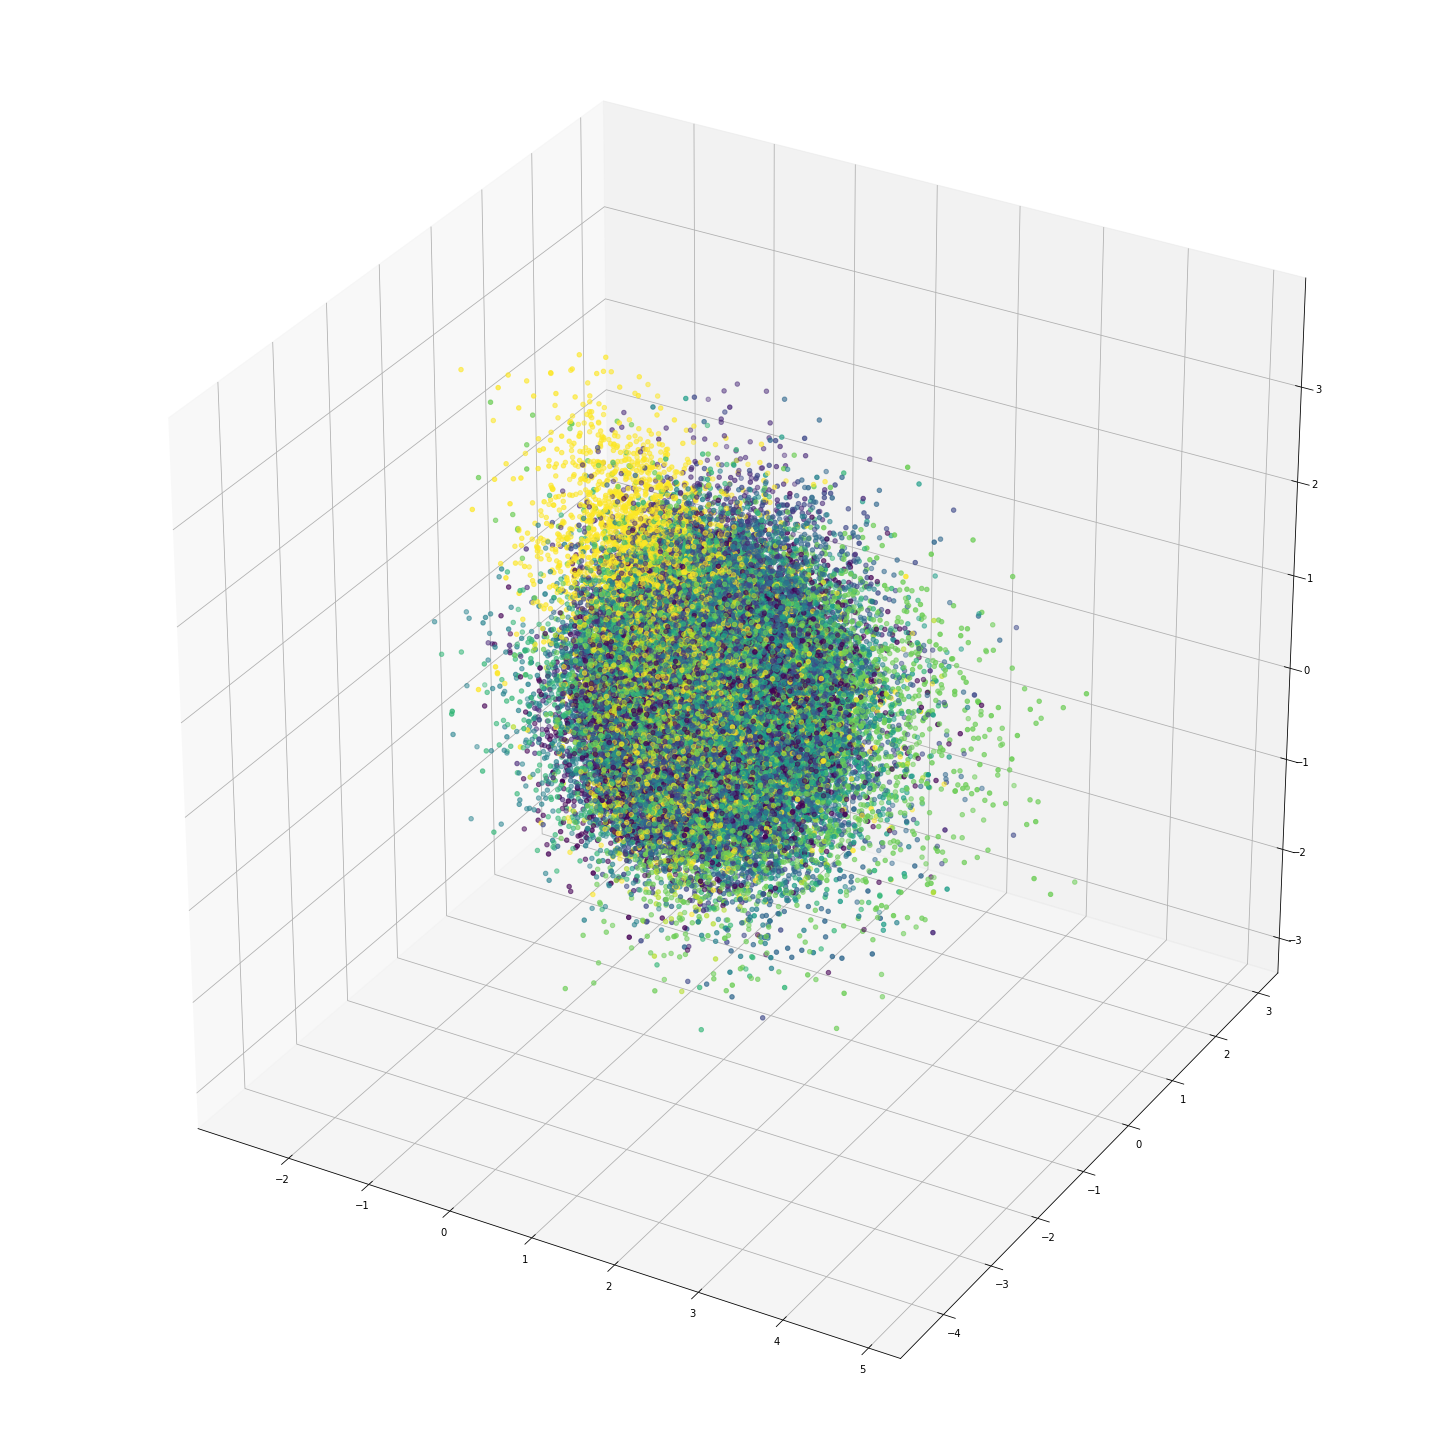

In [414]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20, 20))
ax = Axes3D(fig)

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'olive', 4: 'magenta', 5: 'yellow', 6: 'black',
         7: 'orange', 8: 'pink', 9: 'purple'}

target = np.concatenate((train_kmnist[:][1], test_kmnist[:][1]), axis=0)
all_data = np.concatenate((train_kmnist[:][0][0], test_kmnist[:][0][0]), axis=0)
rec = net.encoder(torch.from_numpy(all_data)).detach().numpy()
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2], c=target)

PCA_kNN from part 1 3D represenation: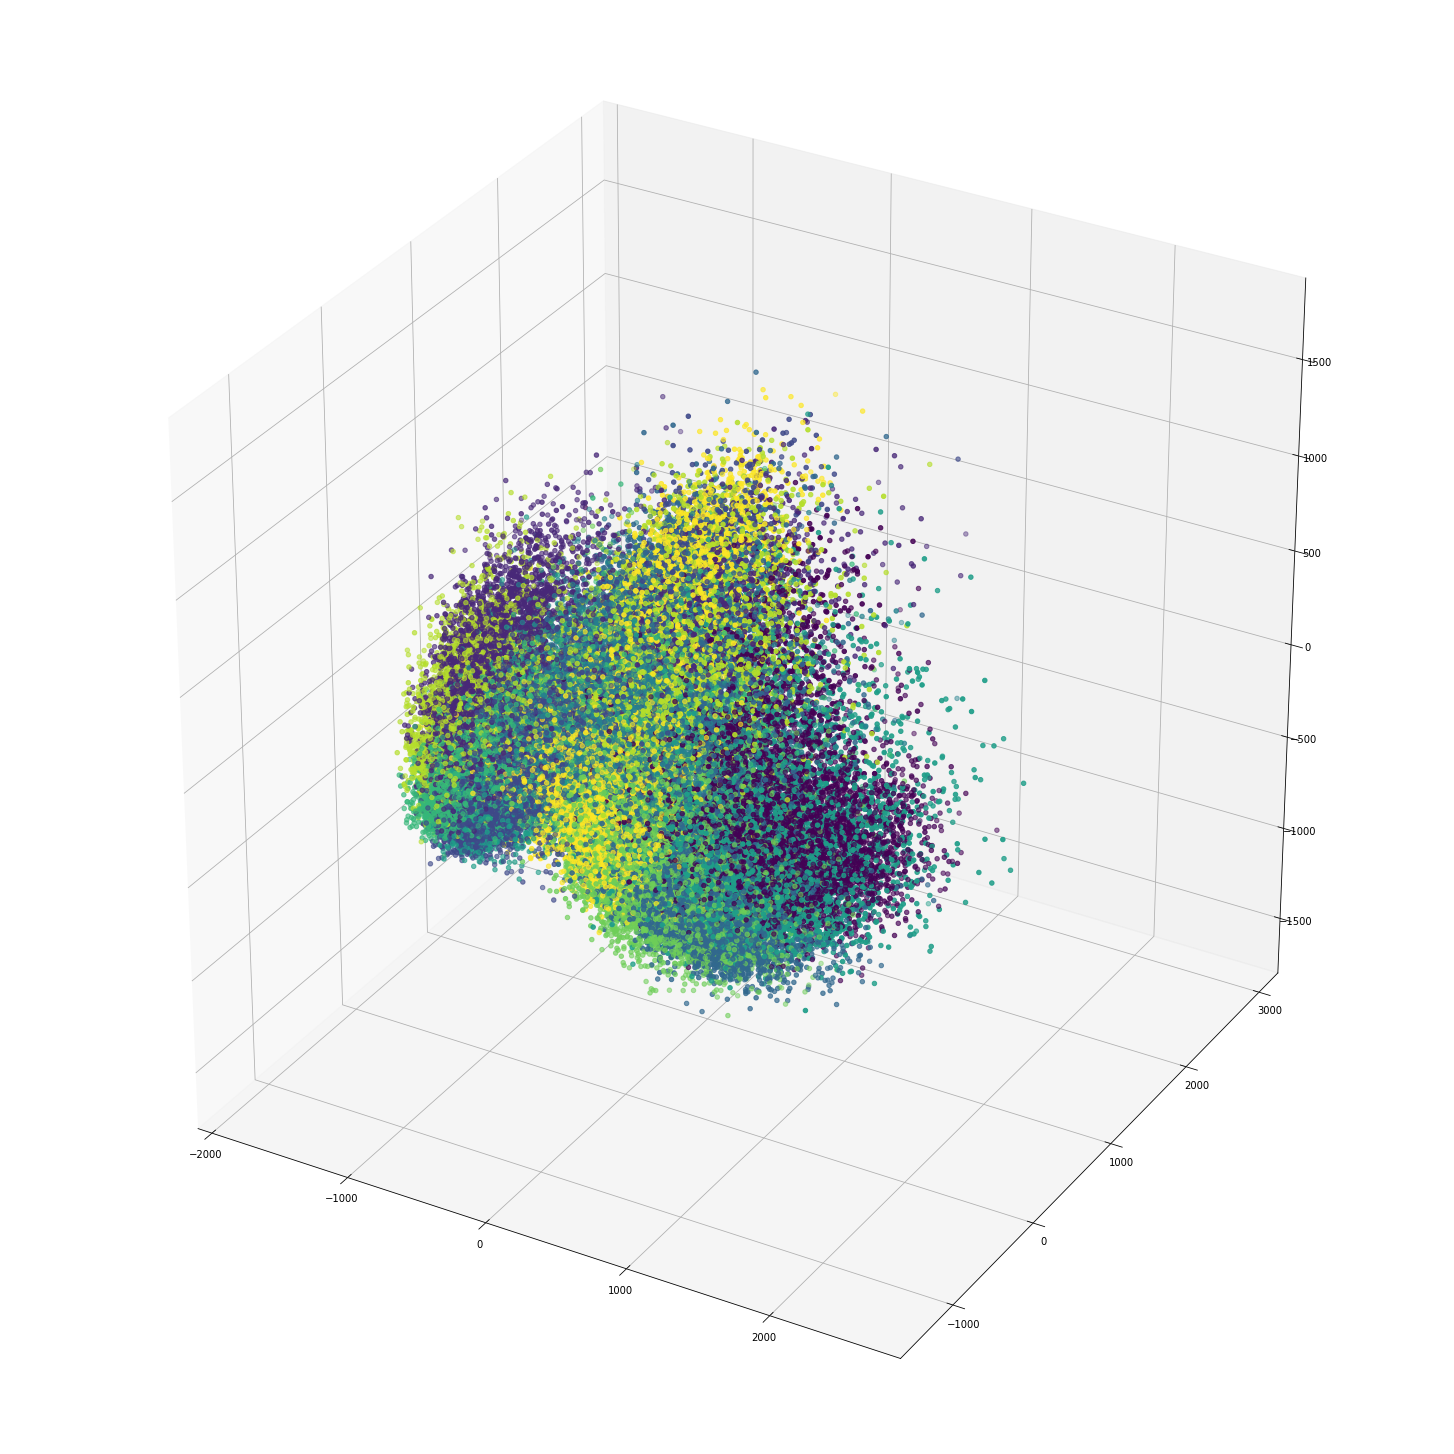

Autoencoder 3D representation: 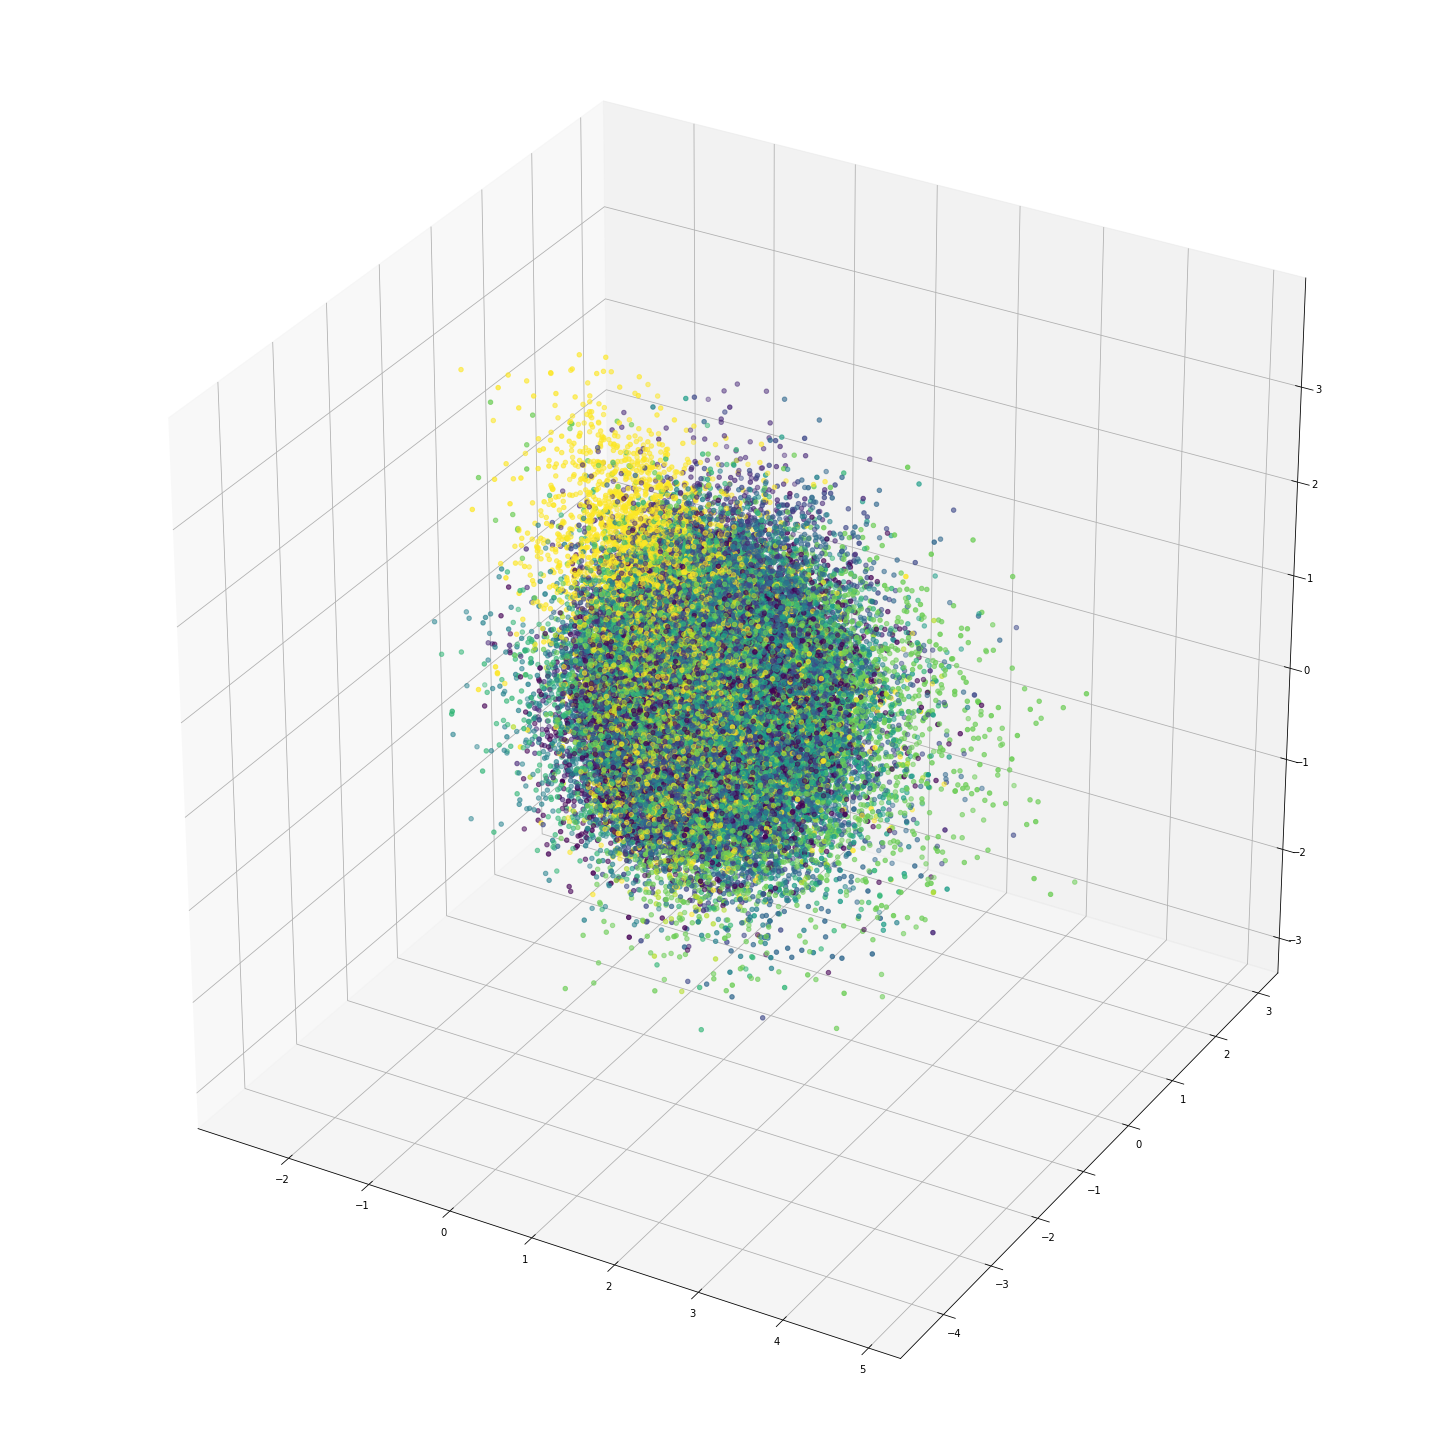

#### 2.4 Get the classification accuracy for the latest features. Use the `KNN` classifier with any hyperparameters you'll choose. Write a couple of sentences comparing the results of `manifold learning` and ` AE`. 

In [411]:
d = [rec[i, :] for i in range(rec.shape[0])]
df = pd.DataFrame(data=d)
df['target'] = target

In [412]:
datka = df.drop('target', axis=1)
targ = df.target

In [393]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
cv_score = []
sk = StratifiedKFold(n_splits=5)

knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
cv_score.append(cross_val_score(knn, datka, targ, cv=sk).mean())
print('cv accuracy: ', np.max(cv_score))

cv accuracy:  0.9552285714285714


- KNN shown 1.5% higher accuracy compared to the case with PCA from Part 1. Isomap could have shown better results, but it's very computationaly heavy, this is why I used PCA in Part 1. Autoencoder, by the way, is very computationaly light(tooks less than 1 sec to encode-decode on my laptop)

### BONUS: Sampling from latent space. (3 points)

Imagine, that you want to generate images, using you AE. To do that, you need to sample from the latent space and then decode the result. Of course, we do not know the exact distribution of the latent space. Therefore, let us assume that latent space distribution is Gaussian:

* Encode all the training images into the latent space
* Calculate mean and covariance matrix ($\mu$ and $\Sigma$)
* Sample  $z$ from the $\mathcal{N}(\mu, \Sigma)$
* Decode $z$ from the previous step to obtain an image

Using the procedure described above, sample 10 images and plot them (they should be similar to those of the initial dataset)

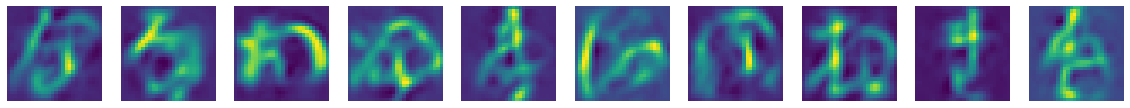

In [437]:
target = train_kmnist[:][1]
encoded = net.encoder(train_kmnist[:][0][0]).detach().numpy()
#calc mean
mean = np.mean(encoded, axis=0)
#calc cov matrix
cov = np.cov(encoded.T)
#draw 10 samples
samples = np.random.multivariate_normal(mean, cov, 10)
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
samples = torch.from_numpy(samples)
#decode samples
decoded = net.decoder(samples.float()).detach().numpy()
for i in range(10):
    ax[i].imshow(decoded[i].reshape(28,28));
    ax[i].axis('off')

**Yeah, so you can get more than `100%` for the homework, good luck!**